### Imports

In [47]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_distribution
from qiskit import Aer, transpile

import matplotlib.pyplot as plt
import numpy as np

### Ideal calculations:

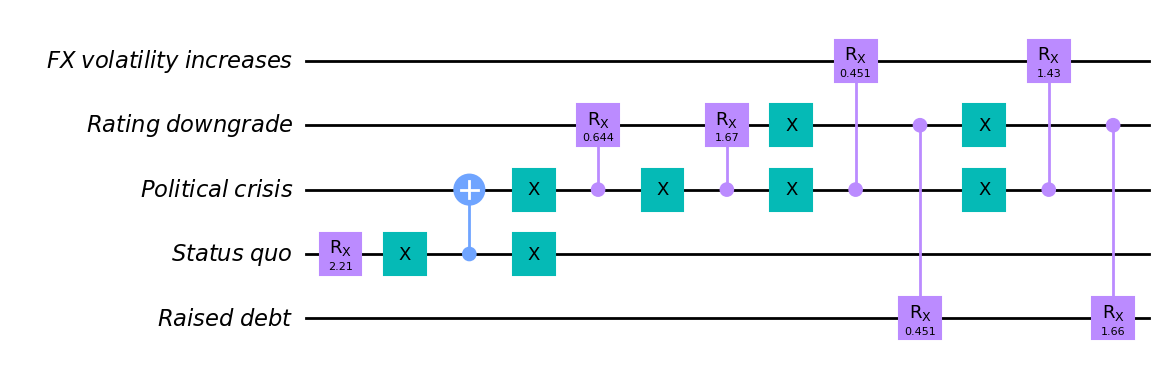

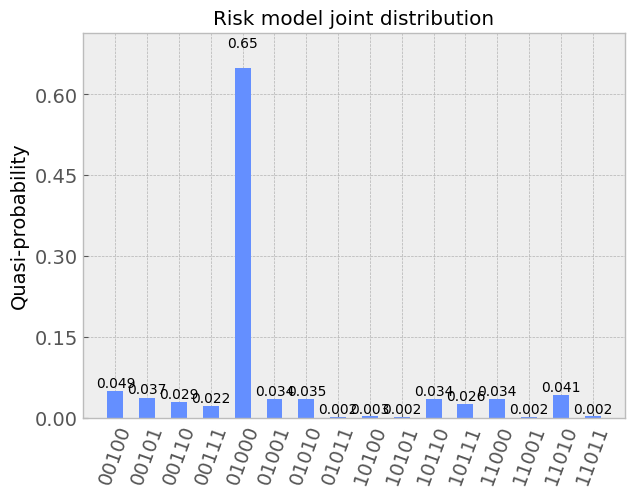

In [48]:
import qiskit as q

np.random.seed(2137)

plt.style.use('ggplot')

# Make separate quantum qubits (for the naming)
status_quo = q.QuantumRegister(1, name='Status quo')
political_crisis = q.QuantumRegister(1, name='Political crisis')
fx_volatility_increases = q.QuantumRegister(1, name='FX volatility increases')
rating_downgrade = q.QuantumRegister(1, name='Rating downgrade')
raised_debt = q.QuantumRegister(1, name='Raised debt')

# Helper converter function
p_to_theta = lambda x: 2*np.arcsin(np.sqrt(x))

# Create the circuit
risk_model = q.QuantumCircuit(fx_volatility_increases, rating_downgrade, political_crisis, status_quo, raised_debt, name='Risk Model')

# Intrinsic status quo
risk_model.rx(p_to_theta(0.8), status_quo)

# Add the CNOT with the control state as '0'
risk_model.x(status_quo)
risk_model.cnot(status_quo, political_crisis)
risk_model.x(status_quo)

# The intrinsic probability for rating downgrade occurs when there's no political crisis
risk_model.x(political_crisis)
risk_model.crx(p_to_theta(0.1), political_crisis, rating_downgrade)
risk_model.x(political_crisis)

# Calculate the P(rating downgrade | political crisis)
p = 1 - (1 - 0.1) * (1 - 0.5)
risk_model.crx(p_to_theta(p), political_crisis, rating_downgrade, ctrl_state='1')

# The same for FX volatility increases
risk_model.x(political_crisis)
risk_model.crx(p_to_theta(0.05), political_crisis, fx_volatility_increases)
risk_model.x(political_crisis)
p = 1 - (1 - 0.05) * (1 - 0.4)
risk_model.crx(p_to_theta(p), political_crisis, fx_volatility_increases, ctrl_state='1')


# The same for Raised debt | rating dowgrade
risk_model.x(rating_downgrade)
risk_model.crx(p_to_theta(0.05), rating_downgrade, raised_debt)
risk_model.x(rating_downgrade)
p = 1 - (1 - 0.3) * (1 - 0.35)
risk_model.crx(p_to_theta(p), rating_downgrade, raised_debt, ctrl_state='1')


# Draw the circuit with matplotlib
display(risk_model.draw(output='mpl'))

risk_model.measure_all()

# simulator = Aer.get_backend('aer_simulator')
# job = simulator.run(risk_model, shots=None)

sampler = Sampler()
job = sampler.run(risk_model, shots=None)
qp = job.result().quasi_dists[0].binary_probabilities()
    

with plt.style.context('bmh'):
    display(plot_distribution(qp, title='Risk model joint distribution'))

### Noisy setup:

In [49]:
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


# QuantumError objects
error_gate1 = depolarizing_error(0.02,1)
error_gate2 = depolarizing_error(0.02,2)

# Add errors to noise model
noise_dep = NoiseModel()
noise_dep.add_all_qubit_quantum_error(error_gate1, ["rx","rz","ry","x"])
noise_dep.add_all_qubit_quantum_error(error_gate2, ["cx"])

# sim_noise = Aer.get_backend('aer_simulator', noise_model=noise_bit_flip)
sim_noise = AerSimulator(noise_model=noise_dep, seed_simulator=2137)

### ZNE mitigation:

Transpilation for the noise model gates to applicable:

In [50]:
t_risk_model = transpile(risk_model, basis_gates=['rx','rz','ry','x','cx'], optimization_level=1)
display(t_risk_model.draw(fold=-1))

global phase: π
                           ┌─────────┐                                                                                                                  ┌───┐┌────────────────────────┐               ┌───┐           ┌─────────────┐          ┌───┐     ┌───────────────────────┐               ┌───┐           ┌──────────────────────┐       ┌──────────┐                   ░ ┌─┐            
FX volatility increases: ──┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.225513405898131) ├───────────────┤ X ├───────────┤ Ry(0.22551) ├──────────┤ X ├─────┤ Ry(-0.71516745604252) ├───────────────┤ X ├───────────┤ Ry(0.71516745604252) ├───────┤ Rz(-π/2) ├───────────────────░─┤M├────────────
                           ├─────────┤            ┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌───┐┌────────────────────────┐┌───┐┌─────────────┐└─┬─┘└──────┬──────────┬──────┘               └─┬─┘           └─────────────┘          └─┬─┘     └─────────┬───┬─────────┘               └─┬─┘           └──────────────────────┘       └──────────┘                   ░ └╥┘┌─┐         
       Rating downgrade: ──┤ Rz(π/2) ├────────────┤ X ├┤ Ry(-0.321750554396642) ├┤ X ├┤ Ry(0.32175) ├┤ X ├┤ Ry(-0.835481873978228) ├┤ X ├┤ Ry(-2.3061) ├──┼─────────┤ Rz(-π/2) ├─────────■──────────────┼──────────────────────────────■─────────┼─────────────────┤ X ├────────────■──────────────┼────────────────────────■──────────────────────────────────────────────────░──╫─┤M├─────────
                           └─────────┘  ┌───┐┌───┐└─┬─┘└────────────────────────┘└─┬─┘└────┬───┬────┘└─┬─┘└────────────────────────┘└─┬─┘└────┬───┬────┘  │         └──────────┘         │              │                  ┌───┐       │         │                 └───┘            │              │                        │                                                  ░  ║ └╥┘┌─┐      
       Political crisis: ───────────────┤ X ├┤ X ├──■──────────────────────────────■───────┤ X ├───────■──────────────────────────────■───────┤ X ├───────■──────────────────────────────┼──────────────■──────────────────┤ X ├───────┼─────────■──────────────────────────────────┼──────────────■────────────────────────┼──────────────────────────────────────────────────░──╫──╫─┤M├──────
                         ┌─────────────┐└─┬─┘├───┤                                         └───┘                                              └───┘                                      │                                 └───┘       │                                            │                                       │                                                  ░  ║  ║ └╥┘┌─┐   
             Status quo: ┤ Rx(-0.9273) ├──■──┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────┼────────────────────────────────────────────┼───────────────────────────────────────┼──────────────────────────────────────────────────░──╫──╫──╫─┤M├───
                         └─┬─────────┬─┘     └───┘                                                                                                                                     ┌─┴─┐┌────────────────────────┐               ┌─┴─┐┌─────────────┐                         ┌─┴─┐┌────────────────────────┐         ┌─┴─┐          ┌───────────────────────┐┌──────────┐ ░  ║  ║  ║ └╥┘┌─┐
            Raised debt: ──┤ Rz(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.225513405898131) ├───────────────┤ X ├┤ Ry(0.22551) ├─────────────────────────┤ X ├┤ Ry(-0.830459135904746) ├─────────┤ X ├──────────┤ Ry(0.830459135904746) ├┤ Rz(-π/2) ├─░──╫──╫──╫──╫─┤M├
                           └─────────┘                                                                                                

In [51]:
from scipy.optimize import curve_fit


def get_locally_folded_circuit(circuit: QuantumCircuit, noise_factor:float):
    
    if noise_factor<1:
        raise ValueError("Noise factor descreasing noise. Only noise amplification is possible.")
    
    folded_circ = QuantumCircuit(*circuit.qregs)
    
    n_folds = int((noise_factor-1)//2)
    additional_fold_chance = ((noise_factor-1)/2)-n_folds
    
    
    for gate in circuit.data:
        folded_circ.append(*gate)
        for _ in range(n_folds):
            folded_circ.append(gate[0].inverse(), gate[1])
            folded_circ.append(*gate)

        if additional_fold_chance>np.random.rand():
            folded_circ.append(gate[0].inverse(), gate[1])
            folded_circ.append(*gate)

    return folded_circ
    
n_shots = 10000
noise_levels = [1.5, 2, 3]


qps_noisy = []
for noise_level in noise_levels:
    folded_circ = get_locally_folded_circuit(t_risk_model.remove_final_measurements(inplace=False),
                                              noise_factor=noise_level)
    
    folded_circ.measure_all()
    print(f"Circuit for noise factor={noise_level}")
    display(folded_circ.draw(fold=-1))
    
    job = sim_noise.run(folded_circ, shots=n_shots)
    qp_noisy = job.result().get_counts()
    qps_noisy.append(qp_noisy)


qps_noisy

Circuit for noise factor=1.5


┌─────────┐  ┌──────────┐┌─────────┐                                                                                                                                       ┌───┐┌────────────────────────┐               ┌───┐           ┌─────────────┐          ┌───┐     ┌───────────────────────┐               ┌───┐           ┌───┐               ┌───┐           ┌──────────────────────┐        ┌──────────┐                                          ░ ┌─┐            
FX volatility increases: ──┤ Rz(π/2) ├──┤ Rz(-π/2) ├┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.225513405898131) ├───────────────┤ X ├───────────┤ Ry(0.22551) ├──────────┤ X ├─────┤ Ry(-0.71516745604252) ├───────────────┤ X ├───────────┤ X ├───────────────┤ X ├───────────┤ Ry(0.71516745604252) ├────────┤ Rz(-π/2) ├──────────────────────────────────────────░─┤M├────────────
                           ├─────────┤  └──────────┘└─────────┘          ┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌──────────┐┌─────────┐└─┬─┘└──────┬──────────┬──────┘               └─┬─┘           └─────────────┘          └─┬─┘     └─────────┬───┬─────────┘               └─┬─┘           └─┬─┘               └─┬─┘           └──────────────────────┘        └──────────┘                                          ░ └╥┘┌─┐         
       Rating downgrade: ──┤ Rz(π/2) ├───────────────────────────────────┤ X ├┤ Ry(-0.321750554396642) ├┤ X ├┤ Ry(0.32175) ├┤ X ├┤ Ry(-0.835481873978228) ├┤ X ├┤ Ry(-2.3061) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├──┼─────────┤ Rz(-π/2) ├─────────■──────────────┼──────────────────────────────■─────────┼─────────────────┤ X ├────────────■──────────────┼───────────────┼────■──────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├─────────
                           └─────────┘     ┌───┐       ┌───┐   ┌───┐┌───┐└─┬─┘└────────────────────────┘└─┬─┘└────┬───┬────┘└─┬─┘└────────────────────────┘└─┬─┘└────┬───┬────┘└──┬───┬───┘└──┬───┬──┘  │         └──────────┘         │              │                  ┌───┐       │         │                 └───┘            │              │               │    │              │                                                                                                   ░  ║ └╥┘┌─┐      
       Political crisis: ──────────────────┤ X ├───────┤ X ├───┤ X ├┤ X ├──■──────────────────────────────■───────┤ X ├───────■──────────────────────────────■───────┤ X ├────────┤ X ├───────┤ X ├─────■──────────────────────────────┼──────────────■──────────────────┤ X ├───────┼─────────■──────────────────────────────────┼──────────────■───────────────■────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫─┤M├──────
                         ┌─────────────┐   └─┬─┘       └─┬─┘   └─┬─┘├───┤                                         └───┘                                              └───┘        └───┘       └───┘                                    │                                 └───┘       │                                            │                                   │                                                                                                                  ░  ║  ║ └╥┘┌─┐   
             Status quo: ┤ Rx(-0.9273) ├─────■───────────■───────■──┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────┼────────────────────────────────────────────┼───────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫──╫─┤M├───
                         └─┬─────────┬─┘                            └───┘                          

Circuit for noise factor=2


┌─────────┐                                                                                                                                                                                                   ┌───┐              ┌───┐               ┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐               ┌───┐                     ┌───┐                    ┌───┐           ┌─────────────┐                                         ┌───┐     ┌───┐               ┌───┐           ┌───────────────────────┐ ┌──────────────────────┐ ┌───────────────────────┐┌───┐     ┌───┐               ┌───┐          ┌──────────────────────┐┌───────────────────────┐┌──────────────────────┐┌──────────┐┌─────────┐┌──────────┐ ░ ┌─┐            
FX volatility increases: ──┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├──────────────┤ X ├───────────────┤ X ├┤ Ry(-0.225513405898131) ├┤ Ry(0.225513405898131) ├┤ Ry(-0.225513405898131) ├───────────────┤ X ├─────────────────────┤ X ├────────────────────┤ X ├───────────┤ Ry(0.22551) ├─────────────────────────────────────────┤ X ├─────┤ X ├───────────────┤ X ├───────────┤ Ry(-0.71516745604252) ├─┤ Ry(0.71516745604252) ├─┤ Ry(-0.71516745604252) ├┤ X ├─────┤ X ├───────────────┤ X ├──────────┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ Rz(-π/2) ├─░─┤M├────────────
                           ├─────────┤            ┌───┐┌───┐┌───┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐└─┬─┘┌────────────┐└─┬─┘┌─────────────┐└─┬─┘└──────┬──────────┬──────┘└──────┬─────────┬──────┘└──────┬──────────┬──────┘               └─┬─┘                     └─┬─┘                    └─┬─┘           └─────────────┘          ┌───┐                          └─┬─┘     └─┬─┘               └─┬─┘           └───────────────────────┘ └──────────────────────┘ └───────────────────────┘└─┬─┘     └─┬─┘               └─┬─┘          └──────────────────────┘└───────────────────────┘└──────────────────────┘└──────────┘└─────────┘└──────────┘ ░ └╥┘┌─┐         
       Rating downgrade: ──┤ Rz(π/2) ├────────────┤ X ├┤ X ├┤ X ├┤ Ry(-0.321750554396642) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.32175) ├┤ X ├┤ Ry(-0.835481873978228) ├┤ Ry(0.835481873978228) ├┤ Ry(-0.835481873978228) ├┤ X ├┤ X ├┤ X ├┤ Ry(-2.3061) ├──┼──┤ Ry(2.3061) ├──┼──┤ Ry(-2.3061) ├──┼─────────┤ Rz(-π/2) ├──────────────┤ Rz(π/2) ├──────────────┤ Rz(-π/2) ├─────────■──────────────┼─────────────────────────┼────────────────────────┼──────────────────────────────■───────┤ X ├────────────────────────────┼─────────┼────■──────────────┼────────────────────────────────────────────────────────────────────────────■──────────────┼────■────┼────■──────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├─────────
                           └─────────┘  ┌───┐┌───┐└─┬─┘└─┬─┘└─┬─┘└────────────────────────┘└─┬─┘└─┬─┘└─┬─┘└────┬───┬────┘└─┬─┘└────────────────────────┘└───────────────────────┘└────────────────────────┘└─┬─┘└─┬─┘└─┬─┘└────┬───┬────┘  │  └────────────┘  │  └─────────────┘  │         └──────────┘              └─────────┘              └──────────┘         │              │                         │                        │                  ┌───┐       │       ├───┤          ┌───┐             │         │    │              │                                                                            │              │    │    │    │              │                                                                                                                         ░  ║ └╥┘┌─┐      
       Political crisis: ───────────────┤ X ├┤ X ├──■────■────■──────────────────────────────■───

Circuit for noise factor=3


┌─────────┐   ┌──────────┐   ┌─────────┐                                                                                                                                                                                                                                                                                                                                                ┌───┐            ┌───┐           ┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐               ┌───┐                     ┌───┐                    ┌───┐           ┌─────────────┐┌──────────────┐┌─────────────┐                    ┌───┐                          ┌───┐          ┌───┐┌───────────────────────┐┌──────────────────────┐┌───────────────────────┐               ┌───┐                     ┌───┐                    ┌───┐           ┌──────────────────────┐┌───────────────────────┐┌──────────────────────┐       ┌──────────┐             ┌─────────┐               ┌──────────┐                                          ░ ┌─┐            
FX volatility increases: ──┤ Rz(π/2) ├───┤ Rz(-π/2) ├───┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├────────────┤ X ├───────────┤ X ├┤ Ry(-0.225513405898131) ├┤ Ry(0.225513405898131) ├┤ Ry(-0.225513405898131) ├───────────────┤ X ├─────────────────────┤ X ├────────────────────┤ X ├───────────┤ Ry(0.22551) ├┤ Ry(-0.22551) ├┤ Ry(0.22551) ├────────────────────┤ X ├──────────────────────────┤ X ├──────────┤ X ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├───────────────┤ X ├─────────────────────┤ X ├────────────────────┤ X ├───────────┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├───────┤ Rz(-π/2) ├─────────────┤ Rz(π/2) ├───────────────┤ Rz(-π/2) ├──────────────────────────────────────────░─┤M├────────────
                           ├─────────┤   ├──────────┤   ├─────────┤                                ┌───┐┌───┐┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐┌──────────────┐┌─────────────┐┌───┐┌───┐┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐┌────────────┐┌─────────────┐└─┬─┘┌──────────┐└─┬─┘┌─────────┐└─┬─┘└──────┬──────────┬──────┘└───────────────────────┘└────────────────────────┘               └─┬─┘                     └─┬─┘                    └─┬─┘           └─────────────┘└──────────────┘└─────────────┘                    └─┬─┘          ┌───┐           └─┬─┘     ┌───┐└─┬─┘└─────────┬───┬─────────┘└──────────────────────┘└───────────────────────┘               └─┬─┘                     └─┬─┘                    └─┬─┘           └──────────────────────┘└───────────────────────┘└──────────────────────┘       └──────────┘             └─────────┘               └──────────┘                                          ░ └╥┘┌─┐         
       Rating downgrade: ──┤ Rz(π/2) ├───┤ Rz(-π/2) ├───┤ Rz(π/2) ├────────────────────────────────┤ X ├┤ X ├┤ X ├┤ Ry(-0.321750554396642) ├┤ Ry(0.321750554396642) ├┤ Ry(-0.321750554396642) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.32175) ├┤ Ry(-0.32175) ├┤ Ry(0.32175) ├┤ X ├┤ X ├┤ X ├┤ Ry(-0.835481873978228) ├┤ Ry(0.835481873978228) ├┤ Ry(-0.835481873978228) ├┤ X ├┤ X ├┤ X ├┤ Ry(-2.3061) ├┤ Ry(2.3061) ├┤ Ry(-2.3061) ├──┼──┤ Rz(-π/2) ├──┼──┤ Rz(π/2) ├──┼─────────┤ Rz(-π/2) ├───────────────────■────────────────────────■───────────────■──────────────┼─────────────────────────┼────────────────────────┼───────────────────────────────────■─────────────────────────■─────────■─────────┼────────────┤ X ├─────────────┼───────┤ X ├──┼────────────┤ X ├─────────────────────■────────────────────────■──────────────■─────

[{'11000': 666,
  '01010': 546,
  '10110': 295,
  '11111': 113,
  '01100': 338,
  '01110': 114,
  '11110': 124,
  '00110': 253,
  '01000': 3749,
  '01001': 618,
  '10111': 220,
  '01101': 292,
  '00100': 346,
  '11010': 658,
  '00101': 329,
  '01011': 93,
  '10001': 6,
  '00111': 217,
  '10100': 81,
  '10000': 41,
  '01111': 88,
  '11100': 70,
  '11011': 109,
  '11001': 115,
  '11101': 49,
  '10011': 28,
  '10101': 58,
  '10010': 77,
  '00010': 53,
  '00000': 185,
  '00011': 21,
  '00001': 48},
 {'01101': 426,
  '00111': 181,
  '11111': 176,
  '00110': 211,
  '01111': 132,
  '11001': 172,
  '11000': 666,
  '10100': 91,
  '01000': 2936,
  '01100': 444,
  '10010': 91,
  '00100': 308,
  '11010': 715,
  '01001': 746,
  '00101': 287,
  '01010': 552,
  '01110': 175,
  '10110': 262,
  '11100': 98,
  '01011': 174,
  '11110': 179,
  '11101': 103,
  '11011': 188,
  '00011': 28,
  '10111': 201,
  '10101': 71,
  '10001': 24,
  '10011': 42,
  '00010': 74,
  '10000': 32,
  '00000': 152,
  '00001': 6

C:\Users\kmoszczy\AppData\Local\Temp\ipykernel_31116\968876056.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exponential_function, noise_levels, state_probs, bounds=(-1., 1.))


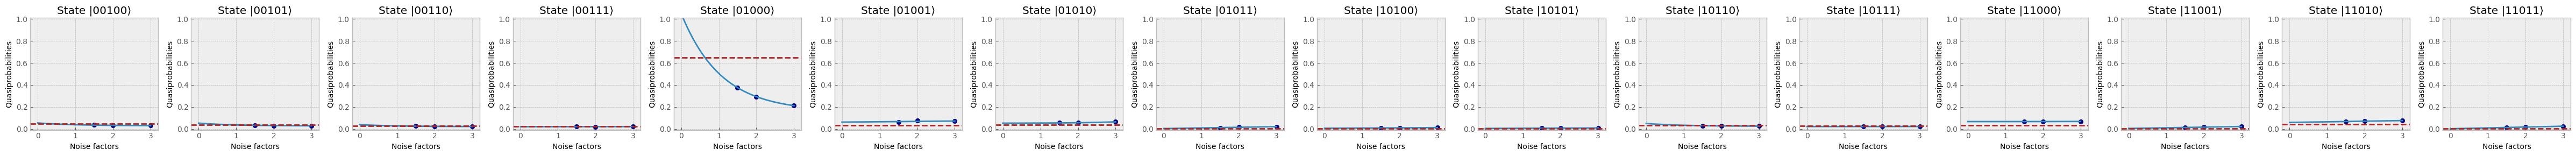

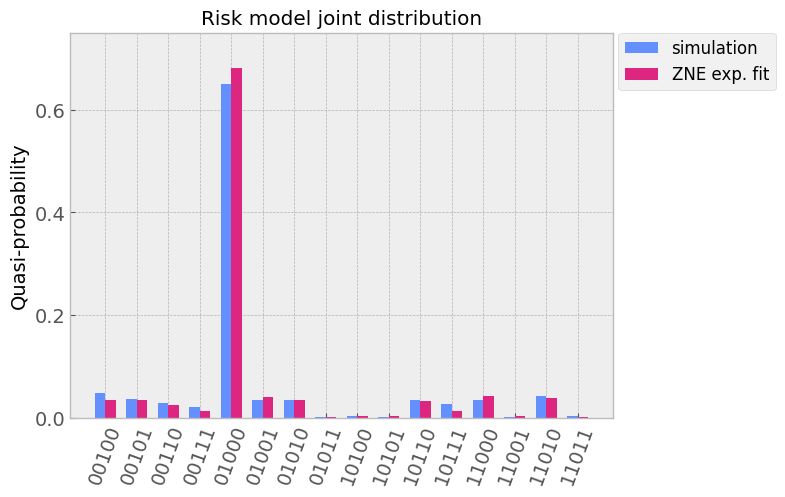

In [52]:
with plt.style.context('bmh'):
    states = list(qp.keys())
    
    fig, axs = plt.subplots(1,len(states),figsize=(3*len(states),3))
    
    mit_values_expfit = []
    for i, state in enumerate(states):
        state_probs = [qp_noisy[state]/n_shots for qp_noisy in qps_noisy]
        # Define the exponential function
        def exponential_function(x, a, b, c):
            return a * np.exp(b * x) + c

        # Fit the data using curve_fit
        popt, pcov = curve_fit(exponential_function, noise_levels, state_probs, bounds=(-1., 1.))
        x_fit = np.linspace(0, max(noise_levels), 101)
        y_fit = exponential_function(x_fit, *popt)
        mit_values_expfit.append(y_fit[0])
        
        axs[i].scatter(noise_levels, state_probs, color='navy', label='raw probs')
        axs[i].plot(x_fit, y_fit, label='exp. func. fit')
        axs[i].axhline(qp[state], linestyle='--', color='firebrick', label=f'ideal prob={qp[state]:.2%}')
        
        axs[i].set_ylim(-0.01, 1.01)
        axs[i].set_xlim(-0.2, max(noise_levels)+0.2)
        axs[i].set_title(f'State |{state}⟩')
        axs[i].set_ylabel("Quasiprobabilities")
        axs[i].set_xlabel('Noise factors')
    # plt.legend()
    plt.tight_layout()
    plt.show()
    
exp_fit = {key:value for key, value in zip(states, mit_values_expfit)}

with plt.style.context('bmh'):
    display(
        plot_distribution([qp,exp_fit], 
                          legend=['simulation','ZNE exp. fit'], 
                          title='Risk model joint distribution',
                          bar_labels=False))

### Objective function:

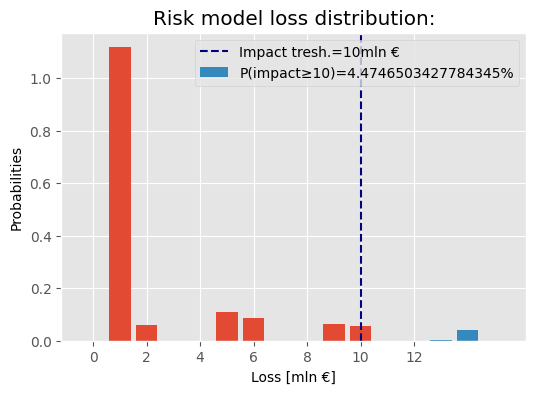

In [63]:
impacts = [8, 4, 2, 1, 0][::-1]
n_events = len(impacts)

qps = np.zeros((2**n_events))

for key, value in exp_fit.items():
    qps[int(key, base=2)] = value

occurencies = [format(i, f'0{n_events}b') for i in range(2**n_events)]
joint_impacts = [sum([impacts[impact_idx] if flag=='1' else 0 for impact_idx, flag in enumerate(occ)]) for occ in occurencies]

unique_joint_impacts = np.unique(joint_impacts)
uji_qps = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps[imp_idx]+= qps[qps_idx]


threshold = 10

plt.subplots(1,1, figsize=(6,4))
plt.bar(unique_joint_impacts, 
        uji_qps)
plt.bar(unique_joint_impacts[unique_joint_impacts>threshold], 
        uji_qps[unique_joint_impacts>threshold],
        label=f'P(impact≥{threshold})={100*uji_qps[unique_joint_impacts>threshold].sum()}%')
plt.axvline(10, color='navy', linestyle='--', label=f'Impact tresh.={threshold}mln €')

plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()

In [64]:
p_impact = 100*uji_qps[unique_joint_impacts>threshold].sum()
print(f"Objective function mitigated output: {p_impact:.3f} %",)

Objective function mitigated output: 4.475 %


You have all neccessary ingredients! Let's go into coding!